# Neural Style transfer algorithm

This Jupyter Notebook demonstrates the implementation of the Neural Style Transfer algorithm using PyTorch. We'll go through the steps of loading and preprocessing images, defining the model architecture, setting up the loss functions, and running the optimization loop to generate a stylized image.

## Imports

First, we import the necessary libraries.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt

## Model Architecture
Here we define the VGG19Features class, which uses the VGG19 model as a feature extractor for style transfer.

In [25]:
class VGG19Features(nn.Module):
    def __init__(self, selected_layers=None):
        super(VGG19Features, self).__init__()
        self.selected_layers = selected_layers
        if self.selected_layers is None:
            self.selected_layers = ["0","5", "10", "19", "28"]  # Default layers for style transfer
        self.model = models.vgg19(weights='IMAGENET1K_V1').features[:29]
        
        for i, feature in enumerate(self.model):
            if isinstance(feature, nn.MaxPool2d):
                self.model[i] = nn.AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)

    def forward(self, x):
        selected_features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
        
            if str(layer_num) in self.selected_layers:
                selected_features.append(x)
        return selected_features

## Image Loading and Preprocessing
We define a function to load and preprocess the images. This function resizes the images, converts them to tensors, and normalizes them.

In [26]:
def image_loader(image_name, imsize, device):
    loader_transform = transforms.Compose([
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_name)
    image = loader_transform(image).unsqueeze(0)
    return image.to(device)

## Gram Matrix Computation
The Gram matrix is used to capture the style of an image. This function computes the Gram matrix of a given tensor.

In [ ]:
def compute_gram_matrix(input_tensor):
    batch_size, channel, height, width = input_tensor.size()
    features = input_tensor.view(batch_size * channel, height * width)
    G = torch.mm(features, features.t())
    return G.div(channel * height * width)

### Hyperparameters,Loss Functions and LBFGS Optimization
Define the closure function for the optimizer and run the optimization loop.

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512
# Load images
style_img = image_loader("the-starry-night.jpg", imsize, device)
original_img = image_loader("tubingen.jpg", imsize, device)
generated_img = original_img.clone().to(device).requires_grad_(True)

# Initialize model and optimizer
model = VGG19Features().to(device).eval()
optimizer =  optim.LBFGS([generated_img])

# Style Transfer Hyperparameters
steps = 100
alpha = 1  # Content weight
beta =  1e7 # Style weight
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.1)

In [27]:
def inverse_img(img):
    inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])
    return inverse_transform(img)

def display_image(losses,content_losses, style_losses):
    # plt.close()
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    axes[0].plot(losses)
    axes[0].set_title("Loss")
    axes[1].plot(content_losses)
    axes[1].set_title("Content Loss")
    axes[2].plot(style_losses)
    axes[2].set_title("Style Loss")
    plt.show()

Step [0/400], Total Loss: 1.6316688060760498


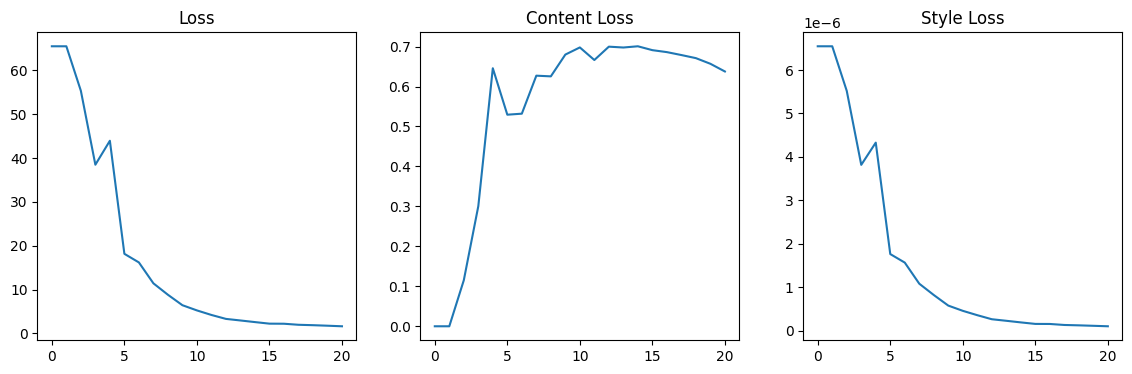

Step [50/400], Total Loss: 0.47512203454971313


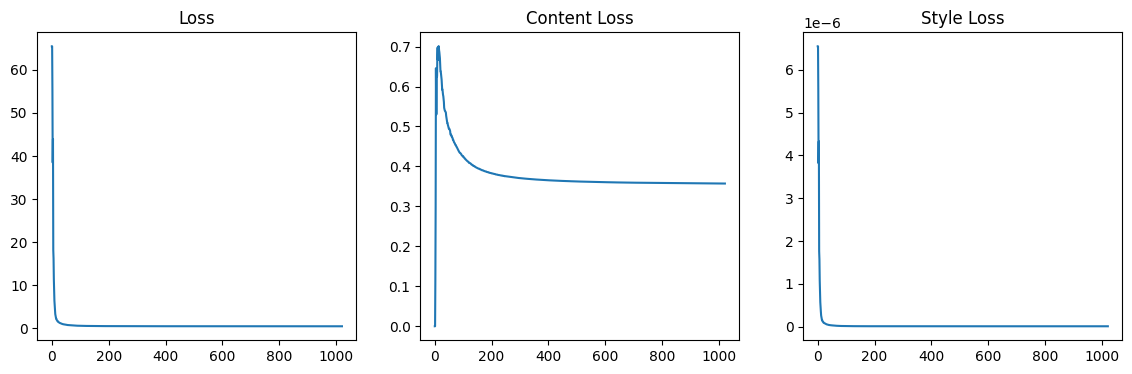

Step [100/400], Total Loss: 0.4724470376968384


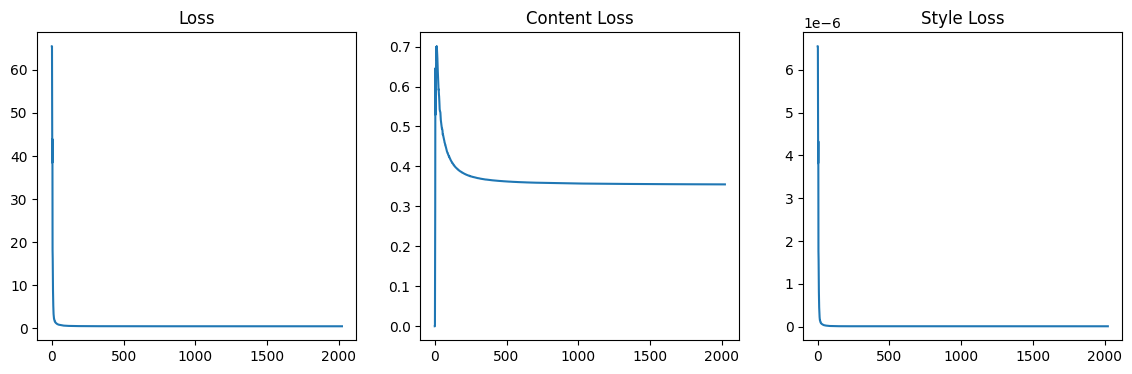

KeyboardInterrupt: 

In [28]:
content_losses, style_losses, losses = [], [], []

def closure():
    optimizer.zero_grad()
    generated_img.requires_grad_(True)
    generated_features = model(generated_img)
    original_features = model(original_img)
    style_features = model(style_img)

    style_loss = 0
    content_loss = 0
    idx = 0

    for gf, of, sf in zip(generated_features, original_features, style_features):
        if idx == 3: 
            content_loss += torch.mean((gf - of) ** 2)

        gram_gf = compute_gram_matrix(gf)
        gram_sf = compute_gram_matrix(sf)
        style_loss += torch.mean((gram_gf - gram_sf) ** 2)
        idx += 1

    total_loss = alpha * content_loss + beta * style_loss
    total_loss.backward()

    content_losses.append(content_loss.item())
    style_losses.append(style_loss.item())
    losses.append(total_loss.item())

    return total_loss

for step in range(steps):
    optimizer.step(closure)

    if step % 50 == 0:
            total_loss = closure()
            print(f"Step [{step}/{steps}], Total Loss: {total_loss.item()}")
            torchvision.utils.save_image(inverse_img(generated_img), f"generated_step_{step}.png")
            display_image(losses, content_losses, style_losses)

## Results

In [41]:
from torchvision.transforms.functional import to_pil_image

def plot_three_images(tensors, titles=['Content Image', 'Style Image', 'Generated Image']):
    """
    Plots three tensor images side by side.

    Parameters:
    tensors (list of torch.Tensor): The image tensors to display.
    titles (list): Titles for each subplot.
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

    for i, tensor in enumerate(tensors):
        tensor = inverse_img(tensor)
        img = to_pil_image(tensor)
        axs[i].imshow(img)
        axs[i].set_title(titles[i])
        axs[i].axis('off')  # Hide axes

    plt.show()

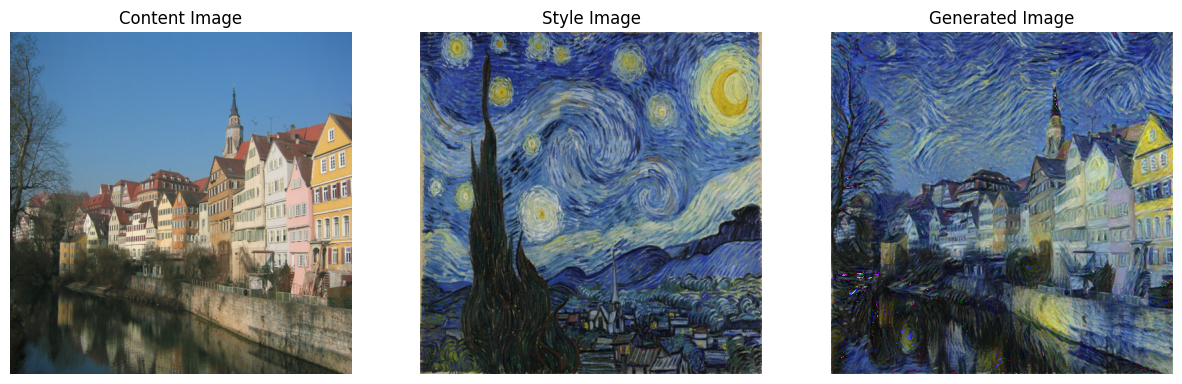

In [43]:
plot_three_images([original_img.squeeze(0), style_img.squeeze(0), generated_img.squeeze(0)])